In [1]:
# 导入必要包
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def readimg(filename, mode):
    # 解决中文路径问题
    raw_data = np.fromfile(filename, dtype=np.uint8)
    img = cv2.imdecode(raw_data, mode)
    return img

In [3]:
test_file_dir = './images/行书/丙/敬世江_5945d30c02c1e30a89de9dc3920a0011adc9aa46.jpg'
img = readimg(test_file_dir,-1)

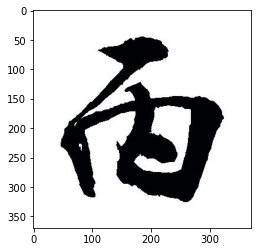

In [4]:
plt.imshow(img)

In [5]:

from skimage.feature import hog
from skimage import data, exposure


In [6]:
def resizeGray(img,new_size):
    img = cv2.resize(img,new_size)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img


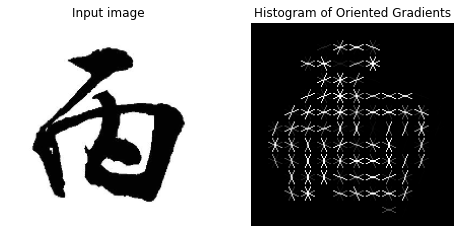

In [7]:
image = resizeGray(img,(200,200))

fd, hog_image = hog(image, orientations=4, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [8]:
import os
import glob
import random

In [9]:
# 列出目录下的文件
def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))

# 读取文件
def image_reader(file_name,new_size):
    img = readimg(file_name,-1)
    img = resizeGray(img,new_size)
    return img

# 从文件中读取特征和标签
def get_file_hog_label_list_from_disk(selectNum=1000):
    char_styles = ['篆书','隶书','草书','行书','楷书']
    # 特征列表和标签列表
    fileFeaturesList = []
    fileLabelList = []
    # 遍历各种风格
    for style in char_styles:
        file_list = glob.glob('./images/'+style+'/*/*')
        print('风格：{style}下共有{num}张图片\n'.format(style=style,num = len(file_list)))
        # 打乱顺序
        random.shuffle(file_list)
        # 挑选固定数量文件
        select_files = file_list[:selectNum]
        
        # 挑选指定数量文件
        for file_item in select_files:
            # 读取文件
            img = image_reader(file_item,(100,100))
            # 提取特征
            features = hog(img, orientations=4, pixels_per_cell=(6,6),cells_per_block=(2,2))
            features = list(features)

            fileFeaturesList.append(features)
            fileLabelList.append(char_styles.index(style))
            
        print('风格：{style}，共挑选了{num}张图片\n\n'.format(style=style,num = len(select_files)))
        
                
    return fileFeaturesList,fileLabelList

           

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [11]:
# 每个字最多挑选1个
fileFeaturesList,fileLabelList = get_file_hog_label_list_from_disk(selectNum=1000)


# 将样本分为训练和测试样本
x_train,x_test,y_train,y_test  = train_test_split(fileFeaturesList,fileLabelList,
                                                  test_size=0.25,random_state=42)


风格：篆书下共有9928张图片

风格：篆书，共挑选了9000张图片


风格：隶书下共有18421张图片

风格：隶书，共挑选了9000张图片


风格：草书下共有42923张图片

风格：草书，共挑选了9000张图片


风格：行书下共有43452张图片

风格：行书，共挑选了9000张图片


风格：楷书下共有20686张图片

风格：楷书，共挑选了9000张图片




In [12]:
# 统计各种类别数量
from collections import Counter
Counter(fileLabelList)

Counter({0: 9000, 1: 9000, 2: 9000, 3: 9000, 4: 9000})

In [13]:
len(fileLabelList)

45000

In [14]:

# SVM分类器
cls = svm.SVC(kernel='rbf')
cls.fit(x_train,y_train)
predictLabels = cls.predict(x_test)

print ( "svm acc:%s" % accuracy_score(y_test,predictLabels))

cls1 = svm.SVC(kernel='linear')
cls1.fit(x_train,y_train)
predictLabels = cls1.predict(x_test)

print ( "svm 1 acc:%s" % accuracy_score(y_test,predictLabels))


cls2 = svm.SVC(kernel='poly')
cls2.fit(x_train,y_train)
predictLabels = cls2.predict(x_test)

print ( "svm  2 acc:%s" % accuracy_score(y_test,predictLabels))



# KNN
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train,y_train)
predictLabels = neigh.predict(x_test)
print  ("KNN acc:%s" % accuracy_score(y_test,predictLabels))



svm acc:0.8216888888888889
svm 1 acc:0.7407111111111111
svm  2 acc:0.8414222222222222
KNN acc:0.7395555555555555


In [15]:
# 保存模型
from joblib import dump, load
dump(cls, './models/svc.joblib') 
dump(neigh, './models/neigh.joblib') 


['./models/neigh.joblib']

In [16]:
# 调用模型
cls = load('./models/svc.joblib') 
predictLabels = cls.predict(x_test)

print ( "svm acc:%s" % accuracy_score(y_test,predictLabels))


svm acc:0.8216888888888889


In [17]:
cm = confusion_matrix(y_test, predictLabels)


<AxesSubplot:>

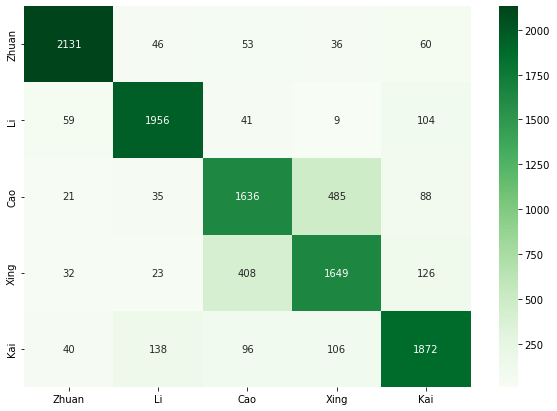

In [18]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm, index = [i for i in ['Zhuan','Li','Cao','Xing','Kai']],
                  columns = [i for i in ['Zhuan','Li','Cao','Xing','Kai']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Greens",fmt="d")